In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.api import VAR
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from alpha_vantage.timeseries import TimeSeries
# Load environment variables from the .env file
load_dotenv('../.env');

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

In [2]:
# Specify the stock symbol and the date range
stock_symbol = "AAPL"
start_date = "2013-01-01"
end_date = "2023-12-18"

# Fetch the stock data
apple_cl = yf.download(stock_symbol, start=start_date, end=end_date)

# Display the stock data
apple_cl.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.769093,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.557430,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.096226,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.001553,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.044609,458707200


In [3]:
#here we are adding technical indicators to the data set as seperate columns

apple_cl['RSI'] = ta.rsi(apple_cl.Close, length=15)
apple_cl['EMAF'] = ta.ema(apple_cl.Close, length=20) #fast moving avg
apple_cl['EMAM'] = ta.ema(apple_cl.Close, length=100) #medium moving avg
apple_cl['EMAS'] = ta.ema(apple_cl.Close, length=150) #slow moving avg


apple_cl['target'] = apple_cl['Adj Close'] - apple_cl.Open
apple_cl['target'] = apple_cl['target'].shift(-1)
apple_cl['target_class'] = [1 if apple_cl.target[i]>0 else 0 for i in range(len(apple_cl))]
apple_cl['target_next_close'] = apple_cl['Adj Close'].shift(-1)

apple_cl.dropna(inplace=True)
apple_cl.reset_index(inplace=True)
apple_cl.drop(['Volume' , 'Close', 'Date'], axis=1, inplace=True)


/var/folders/mf/27g8bmj10ylbpz1wpw3grsfc0000gn/T/ipykernel_83239/692162287.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  apple_cl['target_class'] = [1 if apple_cl.target[i]>0 else 0 for i in range(len(apple_cl))]


In [4]:
apple_cl = apple_cl.iloc[:, 0:11] 

In [5]:
apple_cl.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,target,target_class,target_next_close
0,16.715000,16.853214,16.506071,14.387611,69.038240,15.848586,15.722364,15.912712,-2.185022,0,14.379263
1,16.564285,16.678572,16.491785,14.379263,68.764895,15.920761,15.739870,15.921900,-2.215800,0,14.350629
2,16.566429,16.575001,16.355356,14.350629,64.727822,15.972559,15.754222,15.929089,-2.233575,0,14.146424
3,16.379999,16.445000,16.201786,14.146424,58.633462,15.997112,15.763650,15.933079,-1.768135,0,14.548294
4,16.316429,16.737499,16.308214,14.548294,65.485540,16.063237,15.782022,15.943124,-1.579624,0,15.239662


In [6]:
# Stock closing prices are features and date is the date time index

numeric_features = apple_cl[['Open', 'High', 'Low', 'Adj Close', 'RSI', 'EMAF', 'EMAS', 'EMAM']]
targets = apple_cl[['target', 'target_class', 'target_next_close']]

train_size = int(len(apple_cl) * 0.8)
train_features, test_features = numeric_features[:train_size], numeric_features[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]


# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

# Apply the preprocessing pipeline to numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing_pipeline, numeric_features.columns)
    ])

In [7]:
# Fit and transform the training data
train_features_preprocessed = preprocessor.fit_transform(train_features)

# Transform the test data using the learned parameters from the training data
test_features_preprocessed = preprocessor.transform(test_features)

### Reshape the Data

In [8]:
def reshape_for_lstm(data, time_steps):
    return data.reshape((data.shape[0], time_steps, data.shape[1]))

time_steps = 1  # You can experiment with different time steps
train_features_lstm = reshape_for_lstm(train_features_preprocessed, time_steps)
test_features_lstm = reshape_for_lstm(test_features_preprocessed, time_steps)


### Build The Model

In [9]:
model = Sequential()
time_steps = 1
model.add(LSTM(units=50, activation='relu', input_shape=(time_steps, numeric_features.shape[1])))
model.add(Dense(units=3))  # Assuming you have 3 output columns

model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust the loss function based on your problem

2023-12-18 16:26:17.625217: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-12-18 16:26:17.625243: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-12-18 16:26:17.625248: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-12-18 16:26:17.625285: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-18 16:26:17.625303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
### Train the model

In [11]:
epochs = 50
batch_size = 32

In [12]:
model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size)


Epoch 1/50


2023-12-18 16:26:18.830710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 6s 44ms/step - loss: 1330.2953
Epoch 2/50
66/66 [==============================] - 1s 10ms/step - loss: 1297.4493
Epoch 3/50
66/66 [==============================] - 1s 10ms/step - loss: 1211.3427
Epoch 4/50
66/66 [==============================] - 1s 10ms/step - loss: 1066.0730
Epoch 5/50
66/66 [==============================] - 1s 10ms/step - loss: 884.6727
Epoch 6/50
66/66 [==============================] - 1s 10ms/step - loss: 690.1526
Epoch 7/50
66/66 [==============================] - 1s 10ms/step - loss: 507.0501
Epoch 8/50
66/66 [==============================] - 1s 10ms/step - loss: 347.3014
Epoch 9/50
66/66 [==============================] - 1s 10ms/step - loss: 221.2346
Epoch 10/50
66/66 [==============================] - 1s 10ms/step - loss: 130.2870
Epoch 11/50
66/66 [==============================] - 1s 10ms/step - loss: 71.1239
Epoch 12/50
66/66 [==============================] - 1s 10ms/step - loss: 37.2460
Epoch 13/50
66/66 [===

In [13]:
test_loss = model.evaluate(test_features_lstm, test_targets)
print(f'Test Loss: {test_loss}')

17/17 [==============================] - 2s 60ms/step - loss: 9.2149
Test Loss: 9.214917182922363


17/17 [==============================] - 1s 31ms/step


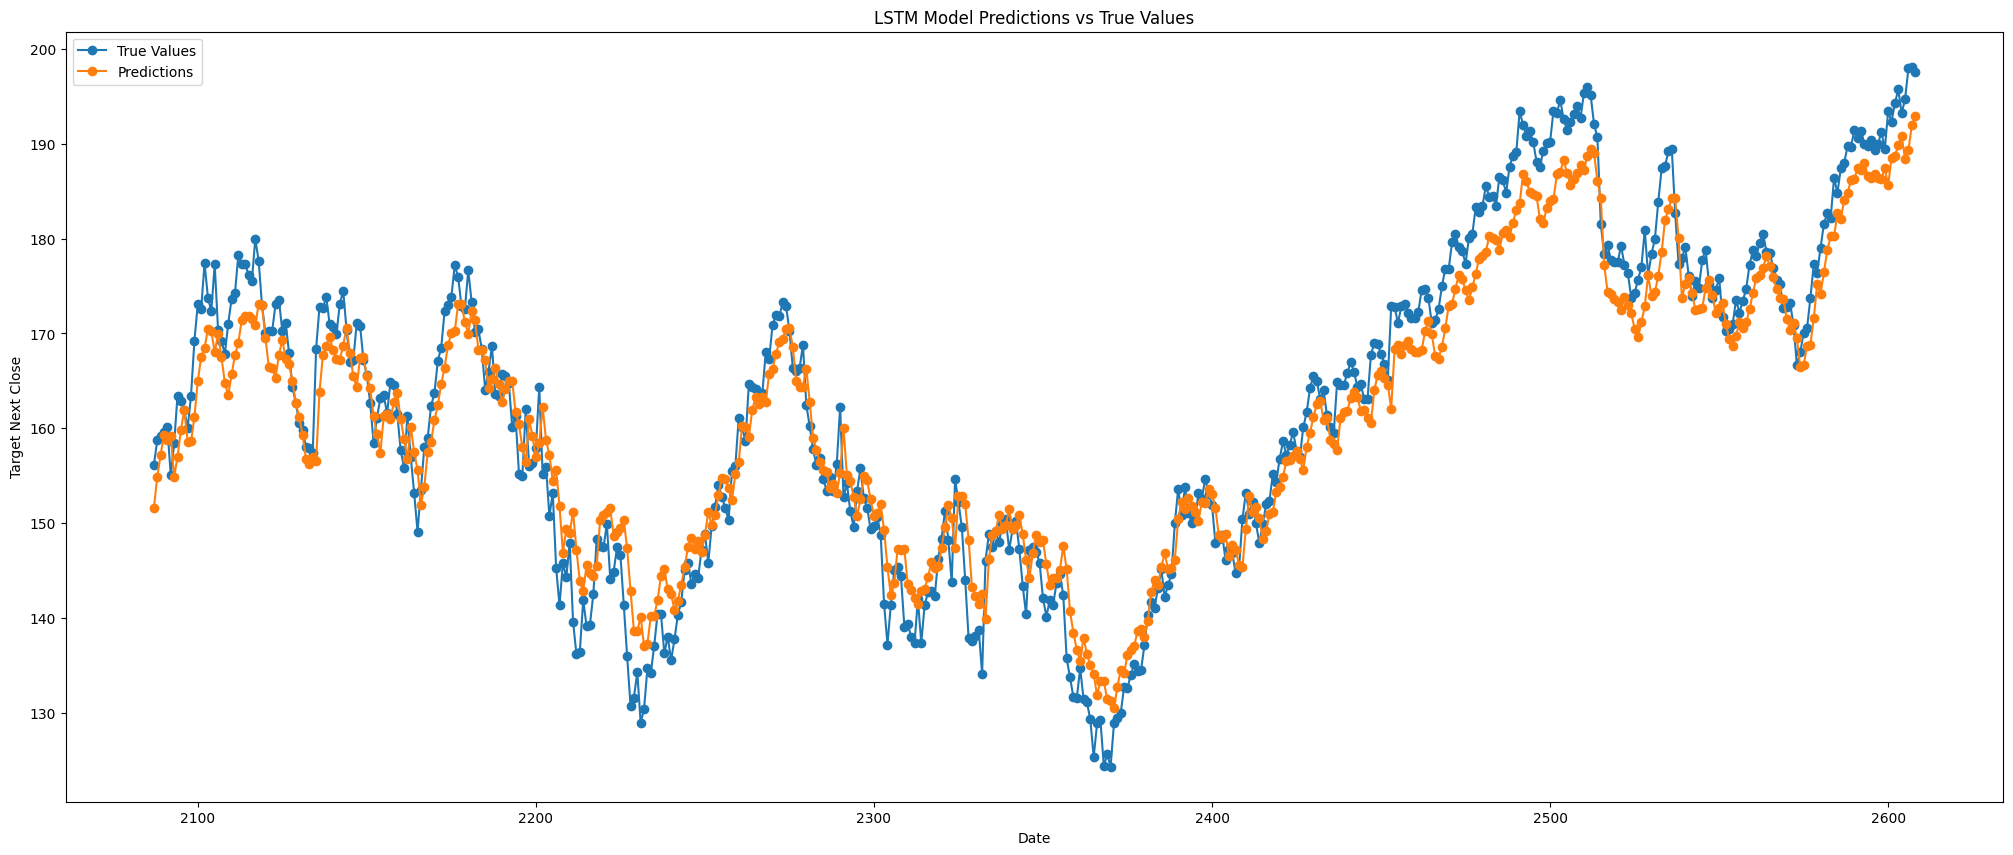

In [14]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LSTM model
predictions = model.predict(test_features_lstm)

# Plotting
plt.figure(figsize=(25, 10))
plt.plot(test_targets.index, test_targets['target_next_close'], label='True Values', marker='o')
plt.plot(test_targets.index, predictions[:, 2], label='Predictions', marker='o')  # Assuming 'target_next_close' is the third column
plt.title('LSTM Model Predictions vs True Values')
plt.xlabel('Date')
plt.ylabel('Target Next Close')
plt.legend()
plt.show()


Epoch 1/50
66/66 [==============================] - 1s 12ms/step - loss: 1.1824 - val_loss: 9.2524
Epoch 2/50
66/66 [==============================] - 1s 11ms/step - loss: 1.1678 - val_loss: 9.4036
Epoch 3/50
66/66 [==============================] - 1s 12ms/step - loss: 1.1585 - val_loss: 9.5909
Epoch 4/50
66/66 [==============================] - 1s 12ms/step - loss: 1.1446 - val_loss: 9.5240
Epoch 5/50
66/66 [==============================] - 1s 12ms/step - loss: 1.1355 - val_loss: 9.4611
Epoch 6/50
66/66 [==============================] - 1s 12ms/step - loss: 1.1234 - val_loss: 9.6213
Epoch 7/50
66/66 [==============================] - 1s 12ms/step - loss: 1.1157 - val_loss: 10.0263
Epoch 8/50
66/66 [==============================] - 1s 12ms/step - loss: 1.1096 - val_loss: 9.6460
Epoch 9/50
66/66 [==============================] - 1s 12ms/step - loss: 1.0992 - val_loss: 9.9935
Epoch 10/50
66/66 [==============================] - 1s 11ms/step - loss: 1.1006 - val_loss: 9.5815
Epoch 11

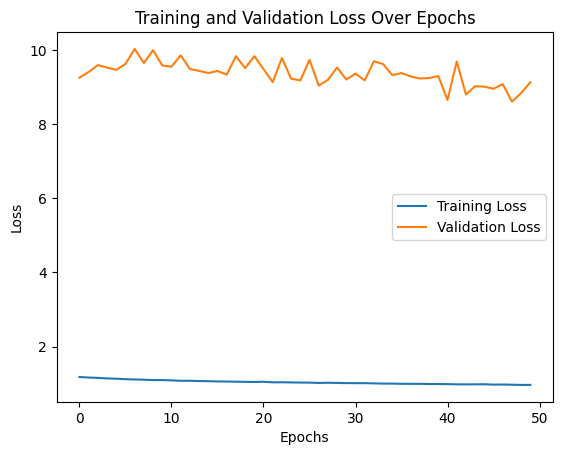

In [15]:
history = model.fit(train_features_lstm, train_targets, epochs=epochs, batch_size=batch_size, validation_data=(test_features_lstm, test_targets))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

predictions = model.predict(test_features_lstm)
mae = mean_absolute_error(test_targets['target_next_close'], predictions[:, 2])  # Assuming 'target_next_close' is the third column
mse = mean_squared_error(test_targets['target_next_close'], predictions[:, 2])
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

17/17 [==============================] - 0s 4ms/step
MAE: 3.50
MSE: 18.29
RMSE: 4.28


In [17]:
from sklearn.metrics import accuracy_score

# Assuming 'target_class' is the classification target column
predictions_class = (predictions[:, 1] > 0.5).astype(int)
accuracy = accuracy_score(test_targets['target_class'], predictions_class)

print(f'Directional Accuracy: {accuracy:.2%}')

Directional Accuracy: 59.20%
